# Simple linear regression

We will use a car data set and our dependent variable is mpg (miles per gallon) vs our independent variable car weight.

In [70]:
#Load libraries
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns

In [71]:
#Load Data
data = pd.read_csv("regression_auto.csv")
data.head()

,make,mpg,weight,weight1,price,foreign,repairs,length
0,AMC,22,2930,2.93,4099,0,3,186
1,AMC,17,3350,3.35,4749,0,3,173
2,AMC,22,2640,2.64,3799,0,3,168
3,Audi,17,2830,2.83,9690,1,5,189
4,Audi,23,2070,2.07,6295,1,3,174


# Response and predictor data Summary

In [72]:
data[['mpg','weight1']].describe().T

,count,mean,std,min,25%,50%,75%,max
mpg,26.0,20.923077,4.757504,14.00,17.2500,21.0,23.00,35.00
weight1,26.0,3.099231,0.695079,2.02,2.6425,3.2,3.61,4.33


# Question
Can the weight of a car statistically significantly predict a car's miles per gallon?

# Hypothesis
H0: Car weight can not  statistically significantly predict a car's miles per gallon
Ha: Car weight can statistically significantly predict a car's miles per gallon

The level of significance
alpha = 0.05

# ASSUMPTIONS
Determine if data meets requirements to perform a linear regression.

Assumption #1: Your response variable should be measured on a continuous scale.            
Assumption #2: Your independent variable should be measured at the continuous or categorical level.         
Assumption #3: There needs to be a linear relationship between the dependent and independent variables. Let’s plot a scatter plot and check           
Assumption #4: You should have independence of observations.          
Assumption #5: There should be no significant outliers.    
Assumption #6: Your data needs to show homoscedasticity, which is where the variances along the line of best fit remain similar as you move along the line.
Assumption #7: Finally, you need to check that the residuals (errors) of the regression line are approximately normally distributed. 

# Check linearity

In [73]:
def find_outliers(x):
    '''
    sample usage
    data_indices, data_values = find_outliers(x['age'])
    print(np.sort(data_values))
    '''
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3 - q1
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indices = list(x.index[(x < floor) | (x > ceiling)])
    outlier_values = list(x[outlier_indices])

    return outlier_indices, outlier_values

In [74]:
# Check outliers for mpg
find_outliers(data['mpg'])

([23], [35])

In [75]:
print(data.iloc[23])

make       Datsun
mpg            35
weight       2020
weight1      2.02
price        4589
foreign         1
repairs         5
length        165
Name: 23, dtype: object


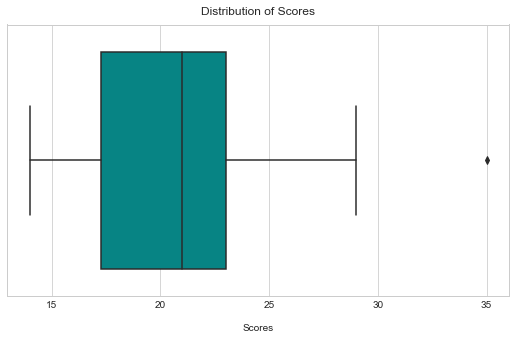

In [76]:
plt.figure(figsize=(9, 5))
sns.boxplot(data['mpg'], color='darkcyan', saturation=0.9)
plt.title("Distribution of Scores", y=1.015)
plt.xlabel("Scores", labelpad=14);

Clearly we have an outlier value of 35 in mpg column

In [77]:
# Check outliers for mpg
find_outliers(data['weight1'])

([], [])

We don't have outliers in the weight column

In [78]:
#Let's drop the column with outliers
#Dropping the outlier rows with Percentiles
def drop_rows_with_outliers(df, column):
    # 1st quartile (25%)
    Q1 = np.percentile(df[column], 25)
    # 3rd quartile (75%)
    Q3 = np.percentile(df[column],75)
    # Interquartile range (IQR)
    IQR = Q3 - Q1

    # outlier step
    outlier_step = 1.5 * IQR

    df = df[(df[column] < (Q3 + outlier_step)) & (df[column] > (Q1 - outlier_step))]
    return df

In [79]:
print(data.shape)
data=drop_rows_with_outliers(data, 'mpg')
print(data.shape)

(26, 8)
(25, 8)


# Check linearity

In [80]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results


def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, height=7)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()


Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


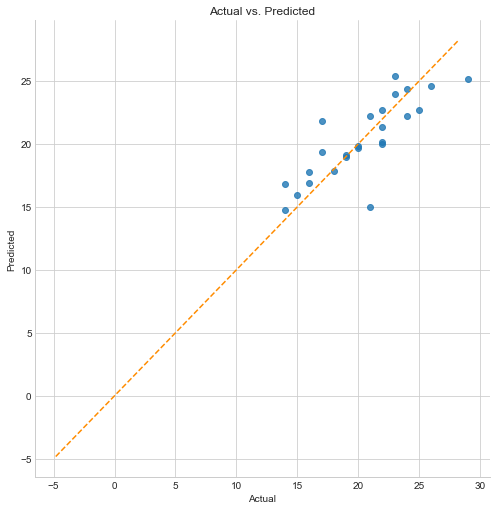

In [81]:
from sklearn.linear_model import LinearRegression
simple_linear_model = LinearRegression()

linear_X, linear_y = data.weight1.values, data.mpg.values
simple_linear_model.fit(linear_X.reshape(-1, 1), linear_y)
linear_assumption(simple_linear_model, linear_X.reshape(-1, 1), linear_y)

# Check Normality law

In [82]:
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Are the error terms are normally distributed?', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')


Are the error terms are normally distributed? 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.36949905438076736
Residuals are normally distributed


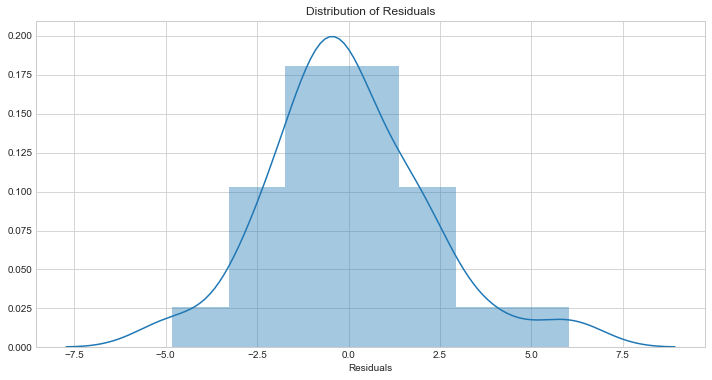


Assumption satisfied


In [83]:
normal_errors_assumption(simple_linear_model, linear_X.reshape(-1, 1), linear_y)

# No Autocorrelation of the Error Terms (Independence of observations)

In [90]:
def autocorrelation_assumption(model, features, label):
    """
    Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                     autocorrelation, then there is a pattern that is not explained due to
                     the current value being dependent on the previous value.
                     This may be resolved by adding a lag variable of either the dependent
                     variable or some of the predictors.
    """
    from statsmodels.stats.stattools import durbin_watson
    print('No Autocorrelation', '\n')
    
    # Calculating residuals for the Durbin Watson-tests
    df_results = calculate_residuals(model, features, label)

    print('\nPerforming Durbin-Watson Test')
    print('-------------------------------------')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')

In [91]:
autocorrelation_assumption(simple_linear_model, linear_X.reshape(-1, 1), linear_y)

No Autocorrelation 


Performing Durbin-Watson Test
-------------------------------------
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.7099889944556814
Little to no autocorrelation 

Assumption satisfied


# Homoscedasticity

In [88]:
def homoscedasticity_assumption(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show()  

Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


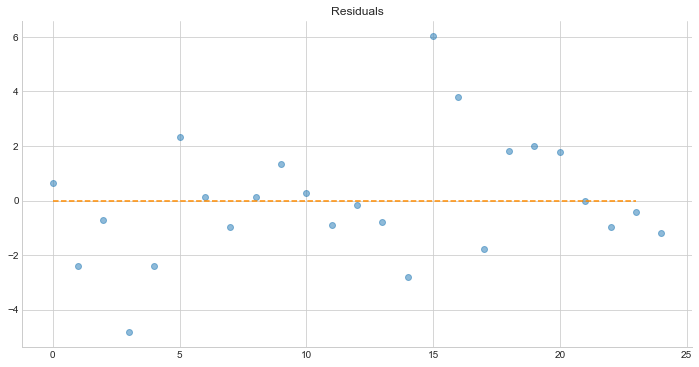

In [89]:
homoscedasticity_assumption(simple_linear_model, linear_X.reshape(-1, 1), linear_y)

# Simple linear regression

In [92]:
import statsmodels.formula.api as smf
model = smf.ols("mpg ~ weight1", data= data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     45.78
Date:                Wed, 25 Mar 2020   Prob (F-statistic):           6.69e-07
Time:                        20:43:40   Log-Likelihood:                -55.113
No. Observations:                  25   AIC:                             114.2
Df Residuals:                      23   BIC:                             116.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     35.1109      2.228     15.762      0.000      30.503      39.719
weight1       -4.6942      0.694     -6.766      0.000      -6.129      -3.259
==============================================================================
Omnibus:                        3.742   Durbin-Watson:                   1.710
Prob(Omnibus):                  0.154   Jarque-Bera (JB):                2.033
Skew:                           0.516   Prob(JB):                        0.362
Kurtosis:                       3.942   Cond. No.                         17.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

A linear regression established that weight of a car could statistically significantly predict mpg (miles covered by the car per gallon), F(1, 23) = 45.78, p < .05 and the weight of a car accounted for 66.6% of the explained variability in miles covered by the car per gallon. The regression equation was: predicted miles covered by the car per gallon = 35.1109 - 4.694 x (weight of the car).
